In [1]:
#hide
from utils import *
from fastai2.vision.widgets import *

In [2]:
key = '813c4eae13df44569dcb5ac74f61d853'

In [11]:
search_images_bing

<function utils.search_images_bing(key, term, min_sz=128)>

In [12]:
results = search_images_bing(key, 'bee')
ims = results.attrgot('content_url')
len(ims)

150

In [13]:
bee_types = 'honey','bumble','sweat'
path = Path('bees')

In [14]:
if not path.exists():
    path.mkdir()
    for o in bee_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bee')
        download_images(dest, urls=results.attrgot('content_url'))


 Download of https://berkshirefarmsapiary.files.wordpress.com/2013/07/imgp8415.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p bees/honey
$ cd bees/honey
$ wget -c https://berkshirefarmsapiary.files.wordpress.com/2013/07/imgp8415.jpg
$ tar xf imgp8415.jpg
 And re-run your code once the download is successful



In [15]:
fns = get_image_files(path)
fns

(#445) [Path('bees/honey/00000000.jpg'),Path('bees/honey/00000001.jpg'),Path('bees/honey/00000004.jpg'),Path('bees/honey/00000007.jpg'),Path('bees/honey/00000002.jpg'),Path('bees/honey/00000010.jpg'),Path('bees/honey/00000009.jpg'),Path('bees/honey/00000011.jpg'),Path('bees/honey/00000012.jpg'),Path('bees/honey/00000005.jpg')...]

In [16]:
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#13) [Path('bees/honey/00000011.jpg'),Path('bees/honey/00000019.jpg'),Path('bees/honey/00000031.jpg'),Path('bees/honey/00000046.jpg'),Path('bees/honey/00000057.jpg'),Path('bees/honey/00000089.jpg'),Path('bees/honey/00000092.jpg'),Path('bees/honey/00000084.jpg'),Path('bees/bumble/00000048.jpeg'),Path('bees/bumble/00000043.jpg')...]

In [17]:
failed.map(Path.unlink);

In [18]:
bees = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
dls = bees.dataloaders(path)

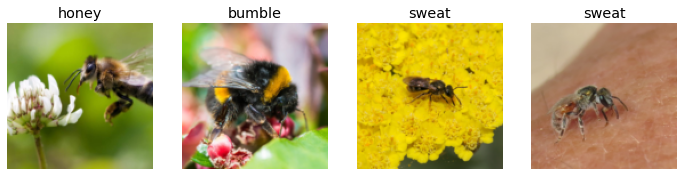

In [20]:
dls.valid.show_batch(max_n=4, nrows=1)

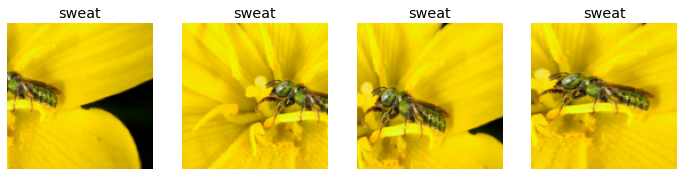

In [21]:
bees = bees.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bees.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4, nrows=1)

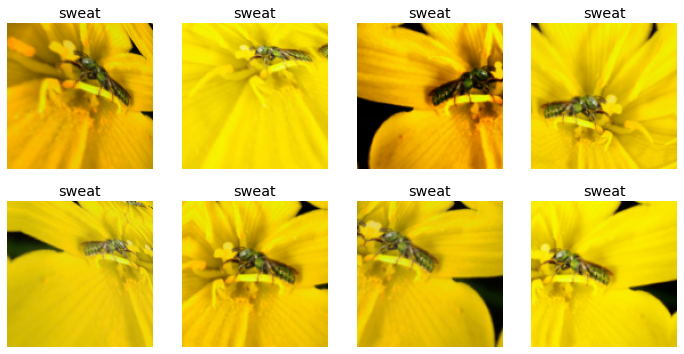

In [22]:
bees = bees.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bees.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, nrows=2)

In [23]:
bees = bees.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bees.dataloaders(path)

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.747522,1.120065,0.449612,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.915768,0.790634,0.263566,00:08
1,0.653210,0.651618,0.201550,00:08
2,0.552643,0.663907,0.170543,00:09
3,0.474529,0.643842,0.170543,00:09


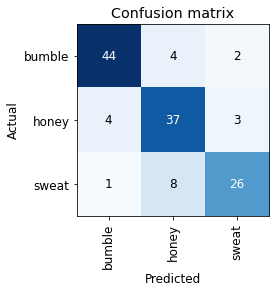

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

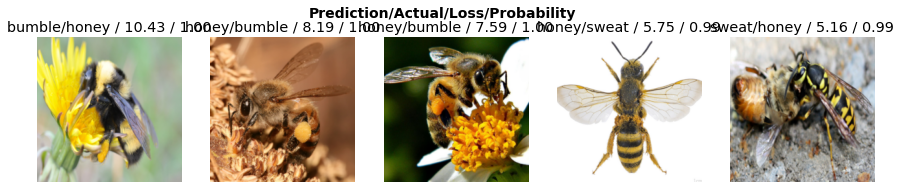

In [26]:
interp.plot_top_losses(5, nrows=1)

In [27]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
#hide
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(cleaner.fns[idx], path/cat)

In [29]:
learn.export()

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [31]:
learn_inf = load_learner(path/'export.pkl')

In [32]:
learn_inf.dls.vocab

(#3) ['bumble','honey','sweat']

In [33]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
img = PILImage.create(btn_upload.data[-1])

In [35]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)

In [37]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: honey; Probability: 0.9392')

In [38]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [40]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [41]:
#hide_output
VBox([widgets.Label('Select your bee!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [42]:
#hide
!pip install voila
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.1.21 OK
